# Detecting Potholes in the Wild

In [2]:
import os
import numpy as np
import glob
import PIL.Image as Image

# pip install torchsummary
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms.v2 as transforms
from torchvision import models
from torchsummary import summary
import torch.optim as optim
from time import time

import matplotlib.pyplot as plt
from IPython.display import clear_output

from torch.utils.data import random_split

In [3]:
pip install pascal-voc-writer

Note: you may need to restart the kernel to use updated packages.


In [4]:
data_path = '02516_pothole_w3/data/Potholes/annotated-images'

In [5]:
import os

 # Replace this with your folder path
# List all files and directories in the specified folder
contents = os.listdir(data_path)

# Print the list of contents
#print("Contents of the folder:")
#for item in contents:
#    print(item)

In [6]:
import xml.etree.ElementTree as ET


def read_content(xml_file: str):

    tree = ET.parse(xml_file)
    root = tree.getroot()

    list_with_all_boxes = []

    for boxes in root.iter('object'):

        filename = root.find('filename').text

        ymin, xmin, ymax, xmax = None, None, None, None

        ymin = int(boxes.find("bndbox/ymin").text)
        xmin = int(boxes.find("bndbox/xmin").text)
        ymax = int(boxes.find("bndbox/ymax").text)
        xmax = int(boxes.find("bndbox/xmax").text)

        list_with_single_boxes = [xmin, ymin, xmax-xmin, ymax-ymin]
        list_with_all_boxes.append(list_with_single_boxes)

    return filename, list_with_all_boxes

In [7]:
_, box = read_content('02516_pothole_w3/data/Potholes/annotated-images/img-1.xml')
print(torch.tensor(box))

tensor([[213, 240, 312, 138]])


In [8]:
class PhC(torch.utils.data.Dataset):
    def __init__(self, transform, data_path=data_path):
        'Initialization'
        self.transform = transform
        self.image_paths = sorted(glob.glob(data_path + '/*.jpg'))
        self.box_paths = sorted(glob.glob(data_path + '/*.xml'))
    
    def __len__(self):
        'Returns the total number of samples'
        return len(self.box_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        box_path = self.box_paths[idx]

        image = Image.open(image_path)
        im_name, box = read_content(box_path)
        Y = torch.tensor(box)
        X = self.transform(image)
        
        return X, Y



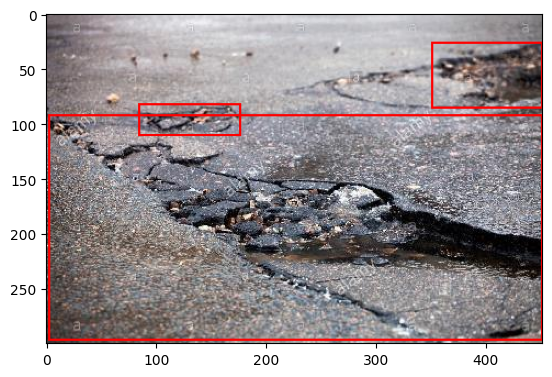

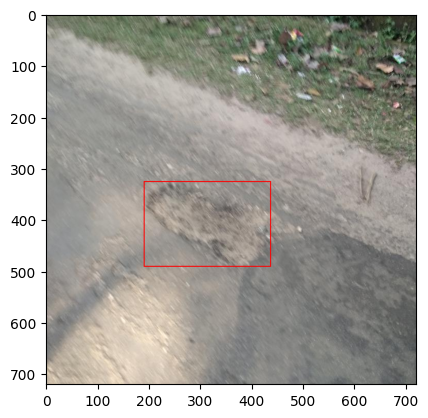

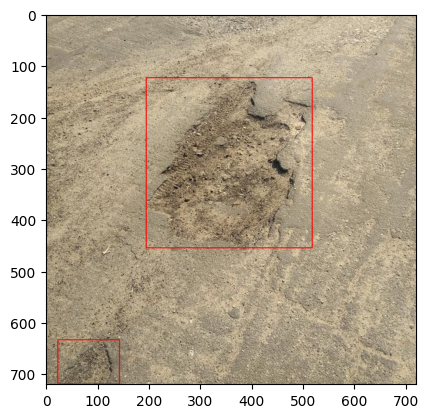

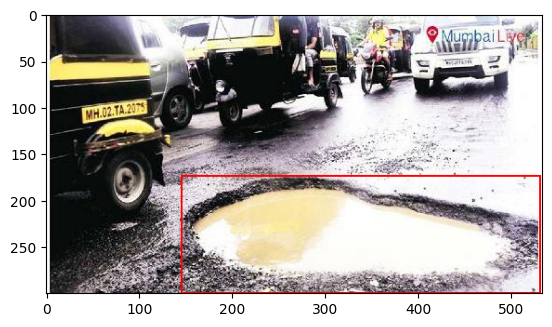

In [9]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt


size = 128
# Define the transform with resizing and center cropping
train_transform = transforms.Compose([
    transforms.ToTensor()
])

# Create PH2 dataset
dataset = PhC(transform=train_transform, data_path=data_path)

# Custom collate function
def my_collate(batch):
    images, boxes = zip(*batch)
    images = torch.stack(images, dim=0)
    return images, boxes

# Create data loader with custom collate function
batch_size = 1
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=3, collate_fn=my_collate)

# Set the maximum number of images to display
max_images_to_display = 4

# Counter for displayed images
displayed_images = 0

# Iterate over the DataLoader
for images, boxes in train_loader:
    # Convert the images to numpy arrays
    images_np = images.permute(0, 2, 3, 1).numpy()

    # Iterate over each sample in the batch
    for i in range(batch_size):
        if displayed_images >= max_images_to_display:
            break

        image_np = images_np[i]
        boxes_sample = boxes[i]

        # Create a PIL image from the numpy array
        image_pil = Image.fromarray((image_np * 255).astype('uint8'))

        # Create a draw object to draw bounding boxes on the image
        draw = ImageDraw.Draw(image_pil)

        # Iterate over each bounding box in the sample
        for box in boxes_sample:
            # Draw the bounding box on the image
            draw.rectangle([box[0], box[1], box[2]+box[0], box[3]+box[1]], outline='red', width=2)

        # Show the image with bounding boxes
        plt.imshow(image_pil)
        plt.show()

        # Increment the counter
        displayed_images += 1

    # Break out of the outer loop if the desired number of images is displayed
    if displayed_images >= max_images_to_display:
        break


In [10]:
pip install opencv-contrib-python numpy

Note: you may need to restart the kernel to use updated packages.


In [11]:
import cv2
def selective_search(image, num_proposals, method="fast"):
    # image = cv2.imread(image_path)
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

    ss.setBaseImage(image)

    if method == "fast":
        ss.switchToSelectiveSearchFast()
    else:
        ss.switchToSelectiveSearchQuality()
    rects = ss.process()
    selected_rects = rects[:num_proposals]
    return selected_rects

In [12]:
# Load an image using OpenCV
image_path = '02516_pothole_w3/data/Potholes/annotated-images/img-631.jpg'
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print(image.shape)

(300, 452, 3)


In [13]:
def calculate_iou(box1, box2):
    """
    Calculate Intersection over Union (IoU) for two bounding boxes.

    Parameters:
    - box1, box2: Bounding boxes in the format (x, y, width, height)

    Returns:
    - IoU score
    """
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    # Calculate coordinates of intersection rectangle
    x_intersection = max(x1, x2)
    y_intersection = max(y1, y2)
    w_intersection = min(x1 + w1, x2 + w2) - x_intersection
    h_intersection = min(y1 + h1, y2 + h2) - y_intersection

    # Check for no overlap
    if w_intersection <= 0 or h_intersection <= 0:
        return 0.0

    # Calculate area of intersection and union
    area_intersection = w_intersection * h_intersection
    area_union = w1 * h1 + w2 * h2 - area_intersection

    # Calculate IoU
    iou = area_intersection / area_union

    return iou

In [14]:
def label_proposals(all_proposals, labels, max_threshold_iou=0.7, min_threshold_iuo=0.3):
    best_bbs = []
    worst_bbs = []
    for label in labels[0]:
        max_iou = max_threshold_iou
        best_bb = None
        worst_bb = None
        for proposal in all_proposals:
            iou = calculate_iou(proposal, label)
            if iou >= max_iou:
                max_iou = iou
                best_bb = (proposal, "pothole")
            if iou < min_threshold_iuo:
                worst_bb = proposal
                if worst_bb is not None:
                    worst_bbs.append(worst_bb)
        if best_bb is not None:
            best_bbs.append(best_bb)
        
    # Ensure that len(worst_bbs) is 3 times the length of best_bbs
    target_length = len(best_bbs) * 3
    if len(worst_bbs) > target_length:
        worst_bbs = worst_bbs[:target_length]
    return best_bbs, worst_bbs

In [15]:
image, labels = next(iter(train_loader))
image = image.squeeze().permute(1, 2, 0).numpy()
all_proposals = selective_search(image, 100,method="notsofast")
best_bbs, worst_bbs = label_proposals(all_proposals, labels)


In [16]:
id = 0
images = []
labels_s = []
best_bbs_s = []
worst_bbs_s = []
for image, labels in train_loader:
    id += 1
    if id == 6:
        break
    image = image.squeeze().permute(1, 2, 0).numpy()
    all_proposals = selective_search(image, 5000, method="notsofast")
    best_bbs, worst_bbs = label_proposals(all_proposals, labels)
    best_bbs_s.append(best_bbs)
    worst_bbs_s.append(torch.tensor(worst_bbs))
    images.append(image)
    labels_s.append(labels)

/tmp/ipykernel_15072/1408667997.py:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  worst_bbs_s.append(torch.tensor(worst_bbs))


In [17]:
print(worst_bbs_s)
print(len(worst_bbs_s))
print(best_bbs_s)
print(len(best_bbs_s))

[tensor([[  0,   0, 113,  15],
        [  0, 118,  16,  11],
        [161,   0, 288, 134],
        [113,  10,  94,  21],
        [225, 268,  33,  32],
        [ 32, 223,  48,  48],
        [223,  20,  49,   8],
        [241,  96,  95,  26],
        [225, 113,  79,  18],
        [304, 145,  33,  31],
        [ 16,   0, 160,  39],
        [240,  58, 209,  69]], dtype=torch.int32), tensor([]), tensor([[425,  94, 105,  73],
        [193, 129,  30,  14],
        [337, 257,  30,  14]], dtype=torch.int32), tensor([[127,  63,  35,  18],
        [160, 560,  16,  32],
        [640, 216,  16,   8]], dtype=torch.int32), tensor([[432,  62, 168,  88],
        [398, 177, 115, 123],
        [176, 102,  17,  10]], dtype=torch.int32)]
5
[[(array([245,  69,  87,  14], dtype=int32), 'pothole'), (array([144, 125,  88,  37], dtype=int32), 'pothole'), (array([106, 161, 150,  36], dtype=int32), 'pothole'), (array([161, 208, 145,  60], dtype=int32), 'pothole')], [], [(array([223, 336, 272, 128], dtype=int32), 

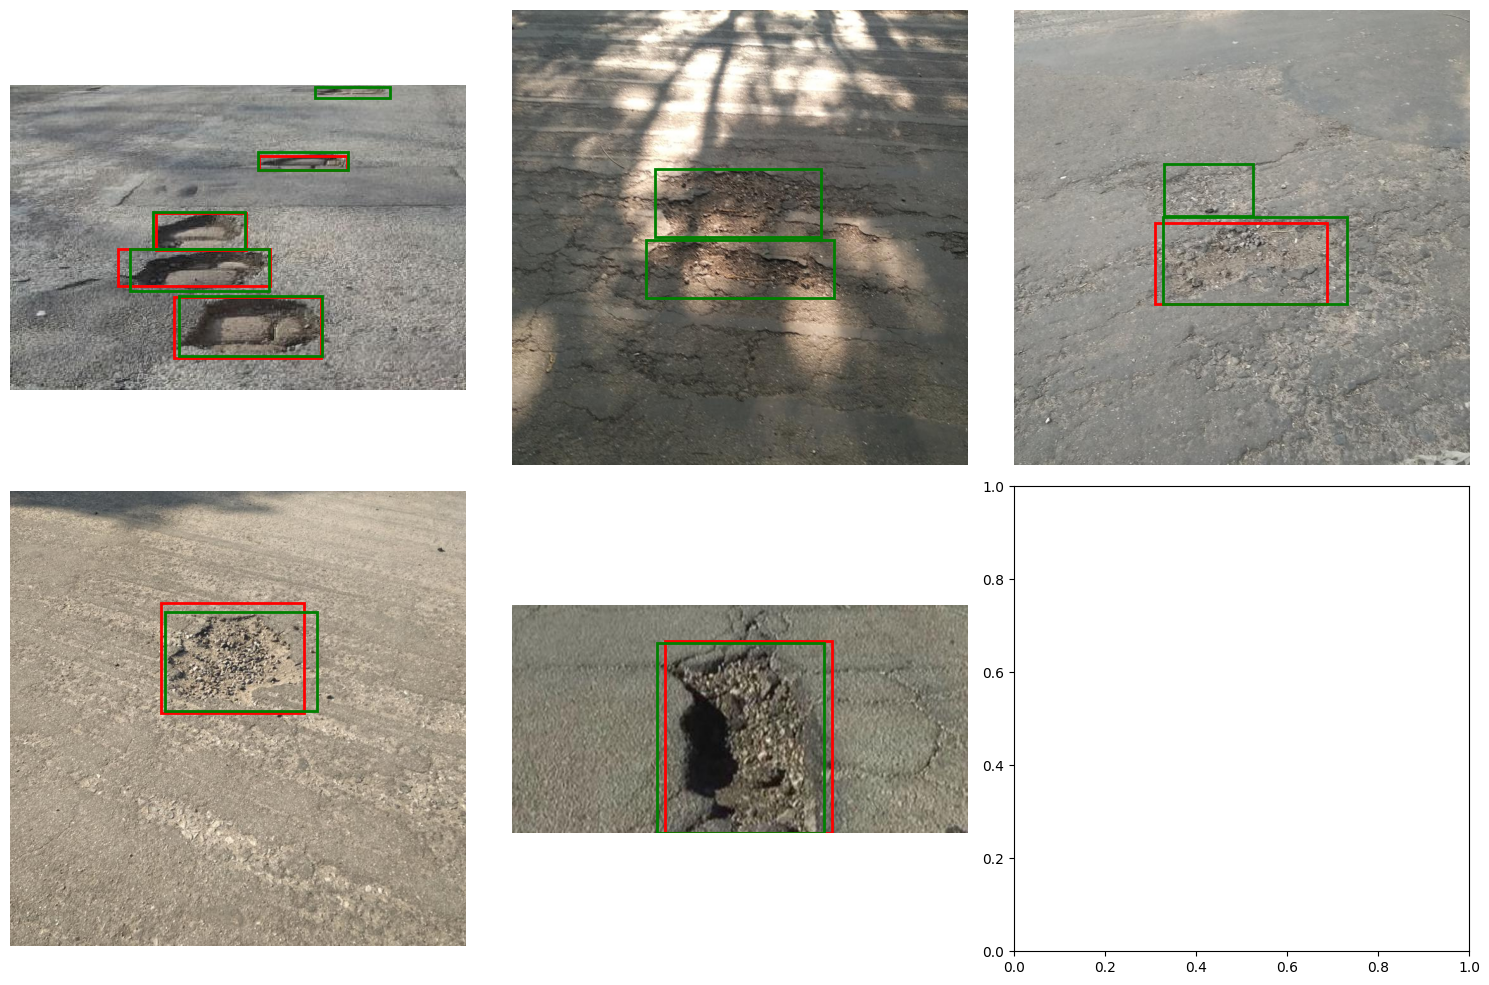

In [18]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, img in enumerate(images):
    axes[idx].imshow(img)
    axes[idx].axis('off')
    cur_bbs = best_bbs_s[idx]
    for bbs in cur_bbs:
        cords = bbs[0]
        if cords is not None:
            rect = patches.Rectangle((cords[0], cords[1]), cords[2], cords[3], linewidth=2, edgecolor='r', facecolor='none')
            axes[idx].add_patch(rect)

    labels = labels_s[idx][0]
    for label in labels:
        if label is not None:
            rect = patches.Rectangle((label[0], label[1]), label[2], label[3], linewidth=2, edgecolor='g', facecolor='none')
            axes[idx].add_patch(rect)   
# Add the rectangle to the Axes
# ax.add_patch(rect)

# Show the plot
plt.tight_layout()
plt.show()


In [19]:
def clip_image(image, coordinates):
    x, y, w, h = map(int, coordinates)
    clipped_segment = image[y:y+h, x:x+w]
    return clipped_segment


In [105]:
# List to store cropped images and labels
cropped_background = []
cropped_labels = []
data = []
classes = []


# Assuming best_bbs_s contains bounding box coordinates for each image
for idx, img in enumerate(images):
    # Assuming best_bbs_s contains bounding box coordinates for each image
    cur_bbs = worst_bbs_s[idx]
    labels = labels_s[idx][0]
    
    # Crop and append images based on bounding boxes
    if cur_bbs.size()[0] != 0:
        for bbs in cur_bbs:
            # Crop the image based on bounding box coordinates
            cropped_img = clip_image(img, bbs)

            # Append the cropped image and labels to the list
            cropped_background.append(torch.tensor(cropped_img))
    for label in labels:
        cropped_img = clip_image(img, label)

        # Append the cropped image and labels to the list
        cropped_labels.append(cropped_img)

data.extend(cropped_background)
data.extend(cropped_labels)

classes.extend(['background']*len(cropped_background))
classes.extend(['pothole']*len(cropped_labels))

In [112]:
print(data[0].shape)

torch.Size([15, 113, 3])


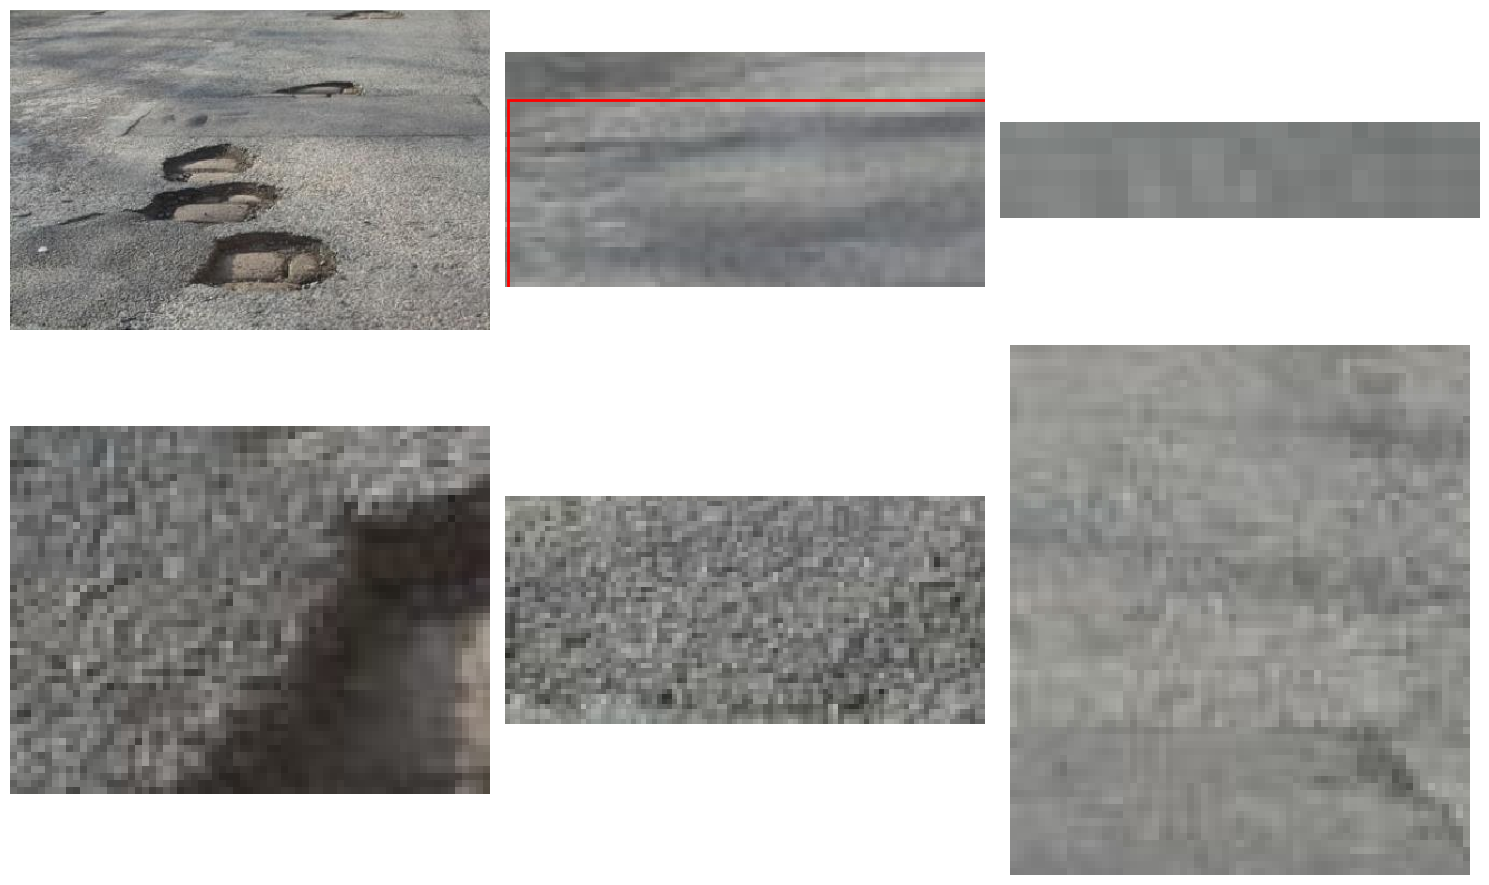

In [107]:
# List to store test images, coordinates, and labels
test_set = []

# Assuming best_bbs_s contains bounding box coordinates for each image
for idx, img in enumerate(images):
    # Run selective search on the image
    all_proposals = selective_search(img, 2000, method="fast")

    # Store the original image and its proposals
    test_set.append({
        'image':img})

    # Crop and append images based on proposals
    for proposal in all_proposals:
        # Crop the image based on proposal coordinates
        cropped_img = clip_image(img, proposal)

        # Append the cropped image and proposals to the list
        test_set.append({
            'image': cropped_img,
            'coordinates': proposal
        })

# Display a few images with proposals
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

# Limit the number of entries to be displayed
max_entries_to_display = min(len(test_set), 6)

for idx in range(max_entries_to_display):
    data_entry = test_set[idx]
    img = data_entry['image']
    proposal = data_entry.get('coordinates', None)

    axes[idx].imshow(img)
    axes[idx].axis('off')

    # Display proposal bounding box if available
    if proposal is not None and proposal.size > 0:
        rect = patches.Rectangle(
            (proposal[0], proposal[1]), proposal[2], proposal[3],
            linewidth=2, edgecolor='r', facecolor='none'
        )
        axes[idx].add_patch(rect)

# Show the plot
plt.tight_layout()
plt.show()
    

In [110]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class CustomDataset(Dataset):
    def __init__(self, data, classes, transform=None):
        self.data = data
        self.classes = classes
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.classes[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Define the transformation with Resize
transform = transforms.Compose([
    transforms.Resize((224, 224))  # Adjust the size as needed
])

# Create a dataset for the training set
train_dataset = CustomDataset(data, classes, transform)

# Create a DataLoader for the training set
batch_size_train = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True, num_workers=4)

for inputs, labels in train_loader:
    print(inputs.shape)  # Print the shape of the input tensor
    print(labels)



/zhome/55/6/203672/myenvv3.11.7/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/zhome/55/6/203672/myenvv3.11.7/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
           ^^^^^^^^^^^^^^^^^^^^
  File "/zhome/55/6/203672/myenvv3.11.7/lib/python3.11/site-packages/torch/utils/data/_utils/fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/zhome/55/6/203672/myenvv3.11.7/lib/python3.11/site-packages/torch/utils/data/_utils/fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
            ~~~~~~~~~~~~^^^^^
  File "/tmp/ipykernel_15072/857919180.py", line 19, in __getitem__
    image = self.transform(image)
            ^^^^^^^^^^^^^^^^^^^^^
  File "/zhome/55/6/203672/myenvv3.11.7/lib/python3.11/site-packages/torchvision/transforms/transforms.py", line 95, in __call__
    img = t(img)
          ^^^^^^
  File "/zhome/55/6/203672/myenvv3.11.7/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1518, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/zhome/55/6/203672/myenvv3.11.7/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1527, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/zhome/55/6/203672/myenvv3.11.7/lib/python3.11/site-packages/torchvision/transforms/transforms.py", line 361, in forward
    return F.resize(img, self.size, self.interpolation, self.max_size, self.antialias)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/zhome/55/6/203672/myenvv3.11.7/lib/python3.11/site-packages/torchvision/transforms/functional.py", line 476, in resize
    _, image_height, image_width = get_dimensions(img)
                                   ^^^^^^^^^^^^^^^^^^^
  File "/zhome/55/6/203672/myenvv3.11.7/lib/python3.11/site-packages/torchvision/transforms/functional.py", line 78, in get_dimensions
    return F_pil.get_dimensions(img)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/zhome/55/6/203672/myenvv3.11.7/lib/python3.11/site-packages/torchvision/transforms/_functional_pil.py", line 31, in get_dimensions
    raise TypeError(f"Unexpected type {type(img)}")
TypeError: Unexpected type <class 'numpy.ndarray'>


In [70]:
# Instantiate the VGG11 model with or without pretrained weights
model = models.vgg16(pretrained=True)

# Modify the classifier for your specific task
# Example: Replace the final fully connected layer for binary classification
model.classifier[6] = nn.Sequential(
    nn.Linear(4096, 1024),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),  # Add a dropout layer with dropout probability of 0.5
    nn.Linear(1024, 2)  # Change 2 to the number of classes in your dataset
)

# Insert batch normalization after each convolutional layer
for layer in model.classifier.children():
    if isinstance(layer, nn.Conv2d):
        model.features[model.features.index(layer)] = nn.Sequential(
            layer,
            nn.BatchNorm2d(layer.out_channels),
            nn.ReLU(inplace=True)
        )

# Set device and define loss function and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [72]:
import torch.optim as optim

# Define the loss function (criterion) and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)  # You can adjust the learning rate

# Training loop
num_epochs = 10  # Adjust the number of epochs as needed

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode

    for inputs, labels in train_loader:
        print(inputs)
        print(labels)
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Calculate the loss
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    # Print the training loss for each epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

print('Training finished.')



/zhome/55/6/203672/myenvv3.11.7/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/zhome/55/6/203672/myenvv3.11.7/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
           ^^^^^^^^^^^^^^^^^^^^
  File "/zhome/55/6/203672/myenvv3.11.7/lib/python3.11/site-packages/torch/utils/data/_utils/fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/zhome/55/6/203672/myenvv3.11.7/lib/python3.11/site-packages/torch/utils/data/_utils/fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
            ~~~~~~~~~~~~^^^^^
  File "/tmp/ipykernel_15072/3248444787.py", line 19, in __getitem__
    image = self.transform(image)
            ^^^^^^^^^^^^^^^^^^^^^
  File "/zhome/55/6/203672/myenvv3.11.7/lib/python3.11/site-packages/torchvision/transforms/transforms.py", line 95, in __call__
    img = t(img)
          ^^^^^^
  File "/zhome/55/6/203672/myenvv3.11.7/lib/python3.11/site-packages/torchvision/transforms/transforms.py", line 137, in __call__
    return F.to_tensor(pic)
           ^^^^^^^^^^^^^^^^
  File "/zhome/55/6/203672/myenvv3.11.7/lib/python3.11/site-packages/torchvision/transforms/functional.py", line 140, in to_tensor
    raise TypeError(f"pic should be PIL Image or ndarray. Got {type(pic)}")
TypeError: pic should be PIL Image or ndarray. Got <class 'torch.Tensor'>


In [ ]:
num_epochs = 10

for epoch in tqdm(range(num_epochs), unit='epoch'):
    # For each epoch
    model.train()
    train_correct = 0

    for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
        data, target = data.to(device), target.to(device)

        # Zero the gradients computed for each weight
        optimizer.zero_grad()
        
        # Forward pass your image through the network
        output = model(data)
        
        # Compute the loss
        loss = criterion(output, target)
        
        # Backward pass through the network
        loss.backward()
        
        # Update the weights
        optimizer.step()

        # Compute how many were correctly classified
        predicted = output.argmax(1)
        train_correct += (target == predicted).sum().cpu().item()
        
    scheduler.step()  # Update the learning rate at the end of each epoch
    # Compute the test accuracy
    
    model.eval()
    test_correct = 0
    correct_indices = []  # List to store indices of correct predictions
    misclassified_images = []
    misclassified_labels = []
    misclassified_predictions = []
    correct_images = []  # List to store correctly predicted images
    correct_labels = []
    correct_predictions = []

    for i, (data, target) in enumerate(test_loader):
        data, target = data.to(device), target.to(device)

        with torch.no_grad():
            output = model(data)

        predicted = output.argmax(1)
        target = target.to(device)

        correct_mask = target == predicted
        correct_indices.extend([i for i, value in enumerate(correct_mask) if value])

        misclassified_mask = target != predicted
        misclassified_images.extend(data[misclassified_mask])
        misclassified_labels.extend(target[misclassified_mask])
        misclassified_predictions.extend(predicted[misclassified_mask])

        correct_images.extend(data[correct_mask])
        correct_labels.extend(target[correct_mask])
        correct_predictions.extend(predicted[correct_mask])

        test_correct += correct_mask.sum().item()